# Boilerplate

Package installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.


In [10]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST(
    "mnist_data/",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = datasets.MNIST(
    "mnist_data/",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)


## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # changed to Sequential, easier to iterate
        self.reg_model = nn.Sequential(
            nn.Linear(28 * 28, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        x = x.view((-1, 28 * 28))
        x = self.reg_model(x)
        return x

    def interval_analysis(self, x, epsilon):
        x = x.view(x.size(0), -1)
        lb = x - epsilon
        ub = x + epsilon
        model_layers = self.reg_model
        for i in range(0, len(model_layers) - 1, 2):
            layer = model_layers[i]
            weight, bias = layer.weight, layer.bias

            curr_lb = torch.nn.functional.relu(
                torch.nn.functional.linear(lb, weight, bias)
            )
            curr_ub = torch.nn.functional.relu(
                torch.nn.functional.linear(ub, weight, bias)
            )

            lb = torch.minimum(curr_lb, curr_ub)
            ub = torch.maximum(curr_lb, curr_ub)

        final_layer = model_layers[-1]
        final_weight, final_bias = final_layer.weight, final_layer.bias

        curr_lb = torch.nn.functional.relu(
            torch.nn.functional.linear(lb, final_weight, final_bias)
        )
        curr_ub = torch.nn.functional.relu(
            torch.nn.functional.linear(ub, final_weight, final_bias)
        )

        lb = torch.minimum(curr_lb, curr_ub)
        ub = torch.maximum(curr_lb, curr_ub)
        return lb, ub


# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image

# Normalization not needed unless training adversarially

model = Net()

model = model.to(device)

In [2]:
def train_model(model, train_loader, test_loader, num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        model.train()
        curr_loss = 0.0

        for i, (image, label) in enumerate(train_loader):
            image, label = image.to(device), label.to(device)
            outputs = model(image)
            loss = F.cross_entropy(outputs, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            curr_loss += loss.item()

        print(f"Epoch {epoch} of {num_epochs}, Loss: {curr_loss/len(train_loader):.3f}")

In [3]:
## train the original model
train_model(model, train_loader, test_loader, 20)
torch.save(model.state_dict(), "weights.pt")

Epoch 0 of 20, Loss: 0.427
Epoch 1 of 20, Loss: 0.182
Epoch 2 of 20, Loss: 0.139
Epoch 3 of 20, Loss: 0.113
Epoch 4 of 20, Loss: 0.092
Epoch 5 of 20, Loss: 0.083
Epoch 6 of 20, Loss: 0.073
Epoch 7 of 20, Loss: 0.065
Epoch 8 of 20, Loss: 0.055
Epoch 9 of 20, Loss: 0.052
Epoch 10 of 20, Loss: 0.046
Epoch 11 of 20, Loss: 0.043
Epoch 12 of 20, Loss: 0.039
Epoch 13 of 20, Loss: 0.035
Epoch 14 of 20, Loss: 0.034
Epoch 15 of 20, Loss: 0.029
Epoch 16 of 20, Loss: 0.026
Epoch 17 of 20, Loss: 0.026
Epoch 18 of 20, Loss: 0.023
Epoch 19 of 20, Loss: 0.021


In [4]:
def test_std_acc(model, test_loader):
    correct = 0
    for j, (image, label) in enumerate(test_loader):
        image, label = image.to(device), label.to(device)
        output = model(image)
        _, pred = torch.max(output, 1)
        correct += (pred == label).sum().item()
    model.train()
    print("Accuracy = {}%".format(float(correct) * 100 / 10000))

In [5]:
test_std_acc(model, test_loader)

Accuracy = 96.92%


In [19]:
def evaluate_robustness(model, test_loader, epsilons):
    robust_counts = {eps: 0 for eps in epsilons}
    total_samples = 0

    for image, label in test_loader:
        total_samples += image.size(0)

        for eps in epsilons:
            lb, ub = model.interval_analysis(image, eps)
            _, pred_lb = torch.max(lb.data, 1)
            _, pred_ub = torch.max(ub.data, 1)
            preds = (pred_lb == label) & (pred_ub == label)

            robust_counts[eps] += preds.sum().item()

    for eps in epsilons:
        print(f"Robust accuracy for epsilon={eps:.2f}: {100 * robust_counts[eps] / total_samples:.4f}%")

    return robust_counts

In [20]:
import numpy as np

epsilons = np.linspace(0.01, 0.1, 10)
robust_accs = evaluate_robustness(model, test_loader, epsilons)

Robust accuracy for epsilon=0.01: 8.3300%
Robust accuracy for epsilon=0.02: 8.1900%
Robust accuracy for epsilon=0.03: 8.1300%
Robust accuracy for epsilon=0.04: 8.0800%
Robust accuracy for epsilon=0.05: 7.9900%
Robust accuracy for epsilon=0.06: 7.9800%
Robust accuracy for epsilon=0.07: 7.9000%
Robust accuracy for epsilon=0.08: 7.9200%
Robust accuracy for epsilon=0.09: 7.9400%
Robust accuracy for epsilon=0.10: 7.9400%


In [21]:
print(robust_accs)

{0.01: 833, 0.020000000000000004: 819, 0.030000000000000006: 813, 0.04000000000000001: 808, 0.05000000000000001: 799, 0.06000000000000001: 798, 0.07: 790, 0.08: 792, 0.09000000000000001: 794, 0.1: 794}


Text(0.5, 1.0, 'Robust Accuracy vs Epsilon')

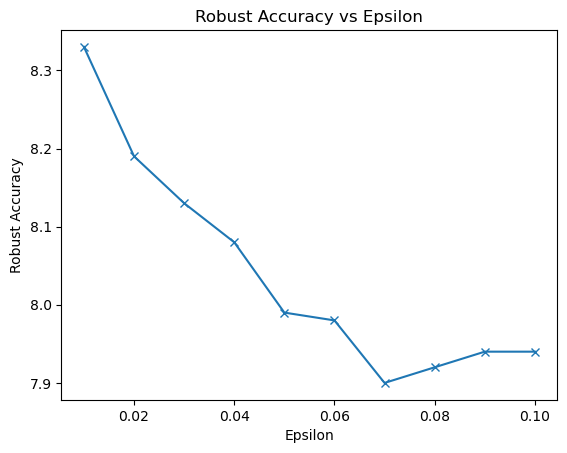

In [26]:
plt.plot(epsilons, [i/100 for i in robust_accs.values()], '-x')
plt.xlabel("Epsilon")
plt.ylabel('Robust Accuracy')
plt.title("Robust Accuracy vs Epsilon")